## Feed Forward Network 
Submitted by Akriti Gupta, Bhumika Singhal and Namita Shukla

In this notebook, we are focusing on creating a shallow consiting of 2 linear layers on which Relu and batch normalization is applied. 

After this we move forward to train our model on a deep network consisting of 4 linear layers on which Relu and Batch Normalization is applied. 

In [14]:
# Here we make all the imports
import pandas as pd
import numpy as np
import random, time
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from tqdm.notebook import tqdm, trange
import seaborn as sns
import json
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix,roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pytorchtools

# Model Definitions

Below we have defined our shallow and Deep layers. We tried different models by increasing and decreasing the number of linear layers. We also tried different dropout values. The following experiment showed us that the best model is the a deep structiure with 4 layers. Moving beyond this we start overfitting 

In [13]:
input_dim = 200
hidden_1 = 1000
hidden_2 = 256
output_dim = 2

class BNShallowNet(nn.Module):
    def __init__(self):
        super(BNShallowNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 2)
        self.bn = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        # output = F.log_softmax(x, dim=1)
        return x

class BNDeepNet(nn.Module):
    def __init__(self):
        super(BNDeepNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)

        #self.fc5 = nn.Linear(32, 2)
        #self.fc6 = nn.Linear(16, 2)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        # x = self.bn4(x)
        # x = F.relu(x)
        # x = self.dropout(x)
        # x = self.fc5(x)
        # x = F.relu(x)
        # x = self.dropout(x)
        # x = self.fc6(x)
        output = F.log_softmax(x, dim=1)
        return output



The below function is used to divide the datasets into small chunks 

In [5]:
def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

This code is used to import the Concat Embeddings of Images and Text and to load the Json files.

In [7]:
concat_embeddings = pd.read_csv("/content/drive/MyDrive/522-project/Embeddings/cocat_pca_embed/ConcatEmbeddings100_train.csv")
concat_embeddings.rename(columns={"0": "id"}, inplace=True)

In [8]:
train_data = pd.read_json("/content/drive/MyDrive/522-project/train.jsonl", lines=True)
train_data.head()
train_data.shape
batch_size = 32
chunked_data = split_dataframe(train_data, batch_size)

In [9]:
preds_train=[]
target_train =[]
preds_val=[]
target_val=[]

Code for training and validating the models 

In [10]:
def train(args, model, device, chunked_data, optimizer,criterion, concat_embeddings):
    model.train()

    for e in range(args['epochs']): 
      preds_train=[]
      target_train =[]
      avg_loss = 0.
      correct = 0
      total = 0
      for batch_idx, (data) in enumerate(chunked_data):
          id = data.id
          
          target = torch.Tensor(data.label.tolist()).to(device)
          a = concat_embeddings[concat_embeddings.id.isin(id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
          if(len(a)==0):
            continue
          data = torch.Tensor(a).to(device)
          optimizer.zero_grad()
          output = model(data)

          loss = criterion(output, target.type(torch.cuda.LongTensor))
          avg_loss += loss.item()
          
          loss.backward()
          _, predicted = torch.max(output.data, 1)
          total += target.size(0)
          #print(predicted.cpu().numpy())
          #print(target.cpu().numpy())
          # r= confusion_matrix(target.cpu().numpy(), predicted.cpu().numpy())
          p = predicted.cpu().numpy()
          t = target.cpu().numpy()
          
          preds_train.extend(p)
          target_train.extend(t)
         

          correct += (predicted.cpu() == target.cpu()).sum()
          optimizer.step()
      #print(preds_train)
      avg_loss /= len(chunked_data)
      print("Epoch : " + str(e)  + "  loss : " + str(avg_loss))
      precision, recall, f1, _ = precision_recall_fscore_support(preds_train, target_train, average='binary')
      r= confusion_matrix(preds_train, target_train)
      print(" precision :"+str(precision) +" recall :"+str(recall)+" f1 "+ str(f1))
      print("confusion_matrix")
      print(r)

      roc_auc = roc_auc_score(preds_train, target_train)
      print("roc",roc_auc)
      accuracy = 100.00 * correct.numpy() / total
      print("Epoch : " + str(e)  + "  accuracy : " + str(accuracy))


In [11]:
def post_train(args, model, device, chunked_data,criterion, concat_embeddings):
    model.eval()

    avg_loss = 0.
    correct = 0
    total = 0
    preds_val=[]
    target_val=[]
    for batch_idx, (data) in enumerate(chunked_data):
        id = data.id
        target = torch.Tensor(data.label.tolist()).to(device)
        a = concat_embeddings[concat_embeddings.id.isin(id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
        if(len(a)==0):
          continue
        data = torch.Tensor(a).to(device)
        output = model(data)
        #print(output.shape,target.shape)


        loss = criterion(output, target.type(torch.cuda.LongTensor))
        avg_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted.cpu() == target.cpu()).sum()
        p = predicted.cpu().numpy()
        t = target.cpu().numpy()
        preds_val.extend(p)
        target_val.extend(t)

    avg_loss /= len(chunked_data)
    precision, recall, f1, _ = precision_recall_fscore_support(preds_val, target_val, average='binary')
    precision1, recall1, thresholds = precision_recall_curve(preds_val, target_val)
    r= confusion_matrix(preds_val, target_val)
    accuracy = 100.00 * correct.numpy() / total
    fpr, tpr, _ = roc_curve(target_val, preds_val)

    print( "  accuracy : " + str(accuracy))
    print("  loss : " + str(avg_loss))
    print(" precision :"+str(precision) +" recall :"+str(recall)+" f1 "+ str(f1))
    print("confusion_matrix")
    print(r)
    roc_auc = roc_auc_score(preds_val, target_val)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)

    for i in range(r.shape[0]):
      for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
    
    print("roc",roc_auc)
    #plt.figure(1)

    #sns.heatmap(r,annot=True)
    plt.show()


    pyplot.plot(recall1, precision1, marker='.', label='Shallow_net')
    # axis labels
    print("Precison Vs Recall")
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.legend()
    pyplot.title('Precision Vs Recall', fontsize=20)
    # show the plot
    pyplot.show()

    print("ROC")

    # plt.plot([0, 1], [0, 1], 'k–')
    plt.plot(fpr, tpr, label='FNN_ROC(area = {:.3f})'.format(roc_auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()




# Shallow : Train

In [15]:

model_shallow = BNShallowNet().to('cuda')
args = {'lr': 0.1, 'momentum': 0.1, "epochs" : 20}
optimizer = optim.SGD(model_shallow.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"

train(args, model_shallow, device, chunked_data, optimizer, criterion, concat_embeddings)

Epoch : 0  loss : 0.6182598650203388
 precision :0.41404438555813183 recall :0.5620503597122302 f1 0.47682624451649813
confusion_matrix
[[4507 1769]
 [ 974 1250]]
roc 0.640091464113604
Epoch : 0  accuracy : 67.72941176470589
Epoch : 1  loss : 0.5777844670683818
 precision :0.4915534945346141 recall :0.6112026359143328 f1 0.5448870938131082
confusion_matrix
[[4537 1535]
 [ 944 1484]]
roc 0.679201449709472
Epoch : 1  accuracy : 70.83529411764705
Epoch : 2  loss : 0.550343451895436
 precision :0.5256707519046042 recall :0.6342925659472423 f1 0.5748958522006883
confusion_matrix
[[4566 1432]
 [ 915 1587]]
roc 0.6977731585988295
Epoch : 2  accuracy : 72.38823529411765
Epoch : 3  loss : 0.5268645806700215
 precision :0.5670751904604173 recall :0.6633087950406819 f1 0.6114285714285714
confusion_matrix
[[4612 1307]
 [ 869 1712]]
roc 0.7212472341481497
Epoch : 3  accuracy : 74.4
Epoch : 4  loss : 0.5203217074723172
 precision :0.5697250745279894 recall :0.6737171954563259 f1 0.6173725771715721
c

# Shallow : Validation

Running the validation loss and accuarcy on the concat embeddings of dev seen and dev unseen csv

  accuracy : 45.370370370370374
  loss : 1.2812809979214388
 precision :0.545 recall :0.34824281150159747 f1 0.42495126705653025
confusion_matrix
[[136  91]
 [204 109]]
roc 0.47368087711643747


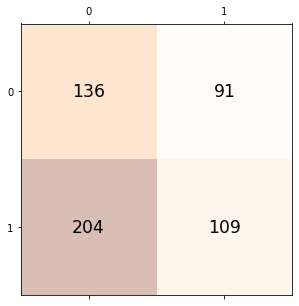

Precison Vs Recall


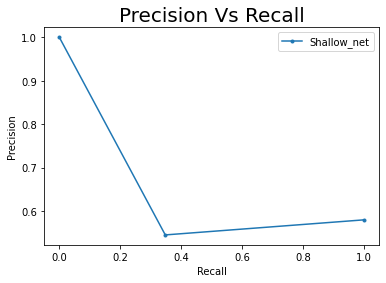

ROC


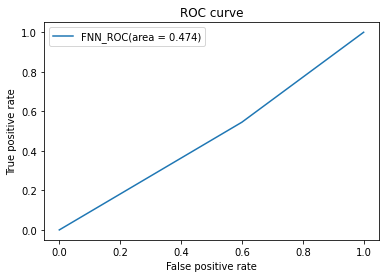

In [17]:

validation_paths = ["/content/drive/MyDrive/522-project/Embeddings/cocat_pca_embed/ConcatEmbeddings100_dev_unseen.csv"]
concat_embeddings_validation = pd.concat( map(pd.read_csv, validation_paths), ignore_index=True)
concat_embeddings_validation.head()
concat_embeddings_validation.rename(columns={"0": "id"}, inplace=True)
batch_size = 32
val_data_unseen = pd.read_json("/content/drive/MyDrive/522-project/dev_unseen.jsonl", lines=True)

val_data_unseen = val_data_unseen[val_data_unseen.id.isin(concat_embeddings_validation.id)]
chunked_data_validation = split_dataframe(val_data_unseen, batch_size)


args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_shallow, device, chunked_data_validation,criterion, concat_embeddings_validation)


# Shallow : Test Unseen


  accuracy : 42.9
  loss : 1.3602725182260786
 precision :0.5866666666666667 recall :0.34591194968553457 f1 0.4352126607319486
confusion_matrix
[[418 310]
 [832 440]]
roc 0.4600438869306793


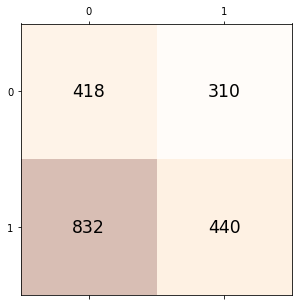

Precison Vs Recall


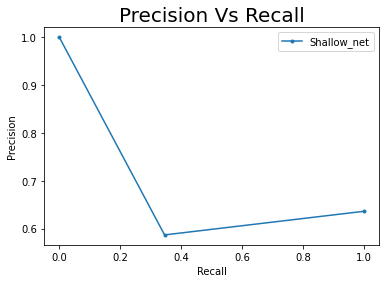

ROC


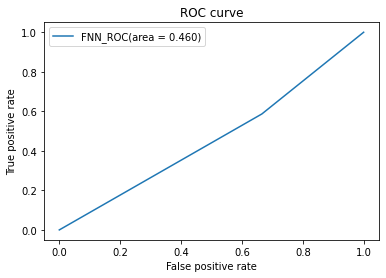

In [18]:
test_unseen_paths = ["/content/drive/MyDrive/522-project/Embeddings/cocat_pca_embed/ConcatEmbeddings100_test_unseen.csv"]

concat_embeddings_test_unseen = pd.concat( map(pd.read_csv, test_unseen_paths), ignore_index=True)
concat_embeddings_test_unseen.rename(columns={"0": "id"}, inplace=True)

batch_size = 32
test_data_unseen = pd.read_json("/content/drive/MyDrive/522-project/test_unseen.jsonl", lines=True)

test_data_unseen = test_data_unseen[test_data_unseen.id.isin(concat_embeddings_test_unseen.id)]
chunked_data_test_unseen = split_dataframe(test_data_unseen, batch_size)

args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_shallow, device, chunked_data_test_unseen,criterion, concat_embeddings_test_unseen)

# Shallow: Test Seen

  accuracy : 51.6
  loss : 1.066411355510354
 precision :0.536734693877551 recall :0.5057692307692307 f1 0.5207920792079208
confusion_matrix
[[253 227]
 [257 263]]
roc 0.516426282051282


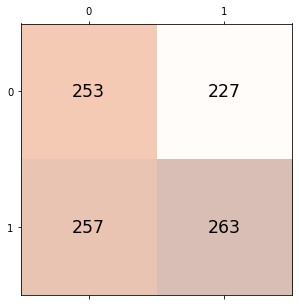

Precison Vs Recall


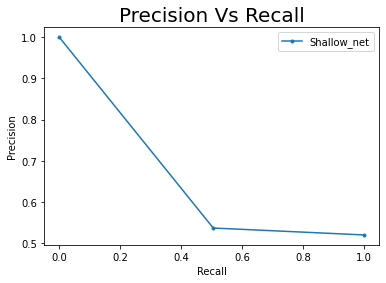

ROC


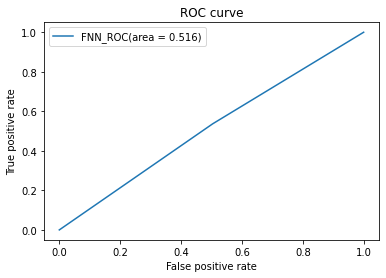

In [19]:
test_seen_paths = ["/content/drive/MyDrive/522-project/Embeddings/cocat_pca_embed/ConcatEmbeddings100_test_seen.csv"]

concat_embeddings_test_seen = pd.concat( map(pd.read_csv, test_seen_paths), ignore_index=True)
concat_embeddings_test_seen.rename(columns={"0": "id"}, inplace=True)

batch_size = 32
test_data_seen = pd.read_json("/content/drive/MyDrive/522-project/test_seen.jsonl", lines=True)

test_data_seen = test_data_seen[test_data_seen.id.isin(concat_embeddings_test_seen.id)]
chunked_data_test_seen = split_dataframe(test_data_seen, batch_size)

args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_shallow, device, chunked_data_test_seen,criterion, concat_embeddings_test_seen)

# Deep Model : Training

In [20]:
import json
model_deep = BNDeepNet().to('cuda')
args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
optimizer = optim.SGD(model_deep.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"

train(args, model_deep, device, chunked_data, optimizer, criterion, concat_embeddings)

Epoch : 0  loss : 0.6694996783831962
 precision :0.05564756541901292 recall :0.3644251626898048 f1 0.09655172413793103
confusion_matrix
[[5188 2851]
 [ 293  168]]
roc 0.5048895312142891
Epoch : 0  accuracy : 63.01176470588236
Epoch : 1  loss : 0.6495946795868695
 precision :0.02186154355746936 recall :0.44594594594594594 f1 0.04167982317650774
confusion_matrix
[[5399 2953]
 [  82   66]]
roc 0.5461889691415553
Epoch : 1  accuracy : 64.29411764705883
Epoch : 2  loss : 0.6429573699719924
 precision :0.024511427625041403 recall :0.5285714285714286 f1 0.04685026907249129
confusion_matrix
[[5415 2945]
 [  66   74]]
roc 0.5881493506493506
Epoch : 2  accuracy : 64.5764705882353
Epoch : 3  loss : 0.6344870401728422
 precision :0.060947333554157004 recall :0.575 f1 0.1102126385145253
confusion_matrix
[[5345 2835]
 [ 136  184]]
roc 0.6142114914425427
Epoch : 3  accuracy : 65.04705882352941
Epoch : 4  loss : 0.6280171468965989
 precision :0.09738323948327261 recall :0.5610687022900763 f1 0.1659610

# Deep Model: Validation

  accuracy : 58.148148148148145
  loss : 0.762227317866157
 precision :0.27 recall :0.40298507462686567 f1 0.32335329341317365
confusion_matrix
[[260 146]
 [ 80  54]]
roc 0.5216895816484082


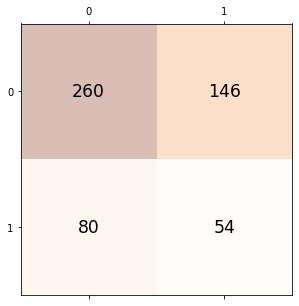

Precison Vs Recall


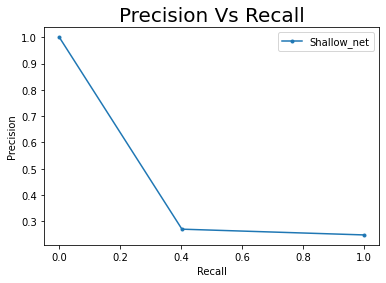

ROC


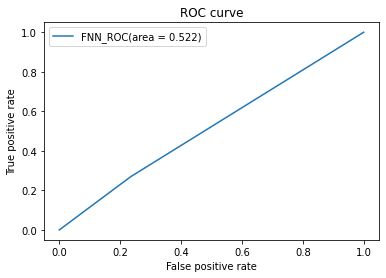

In [21]:
args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_deep, device, chunked_data_validation,criterion, concat_embeddings_validation)


# Deep Model: Test Seen 

  accuracy : 53.3
  loss : 0.7906088754534721
 precision :0.23061224489795917 recall :0.5566502463054187 f1 0.32611832611832614
confusion_matrix
[[420 377]
 [ 90 113]]
roc 0.5418132034538385


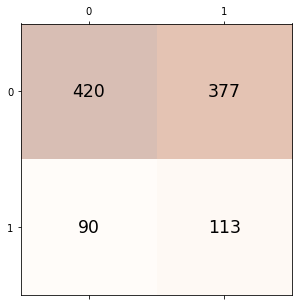

Precison Vs Recall


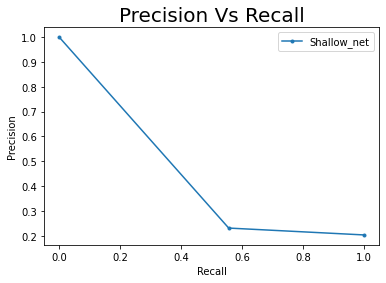

ROC


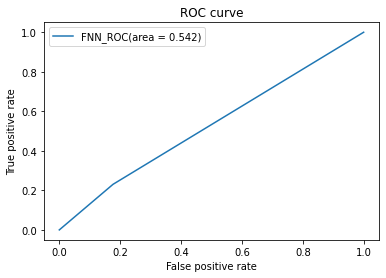

In [22]:
args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_deep, device, chunked_data_test_seen,criterion, concat_embeddings_test_seen)

# Deep Model: Test UnSeen

  accuracy : 55.1
  loss : 0.7618400657933856
 precision :0.23466666666666666 recall :0.352 f1 0.28159999999999996
confusion_matrix
[[926 574]
 [324 176]]
roc 0.4846666666666666


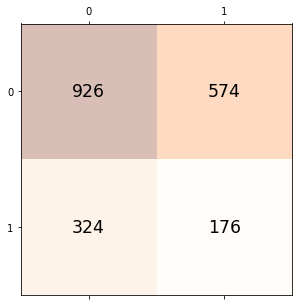

Precison Vs Recall


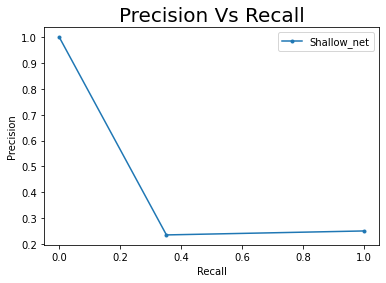

ROC


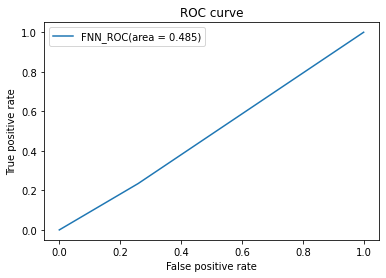

In [23]:
args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_deep, device, chunked_data_test_unseen,criterion, concat_embeddings_test_unseen)